# H02A5A Computer Vision Project - Incisor Segmentation

## Imports

In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark
from incisorseg.utils import *
from asm.shape import Shape, get_bounding_box
from asm.shapemodel import ShapeModel
from asm.greymodel import GreyModel

## Reading the dataset

In [2]:
data = Dataset('../data/')

## Sample plots

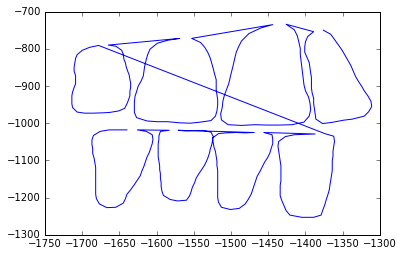

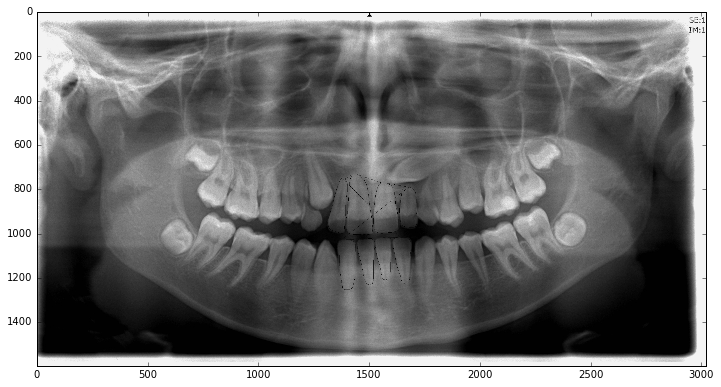

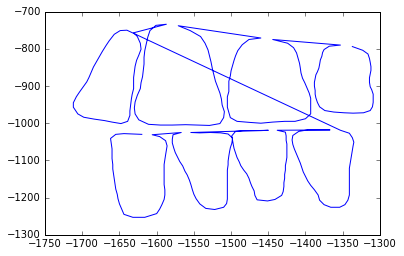

(1597, 3023)


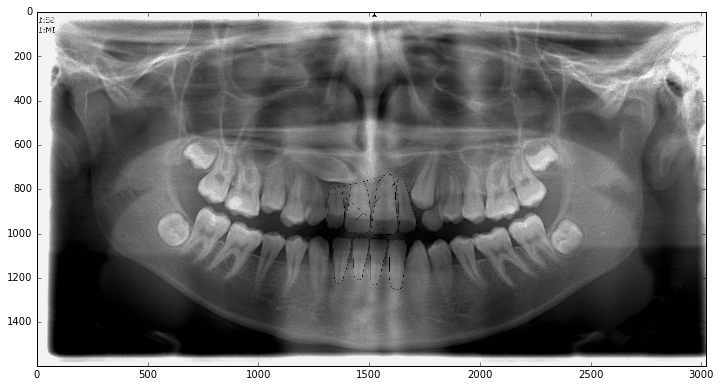

In [3]:
img,mimg = data.get_training_images([0])
l,ml = data.get_training_image_landmarks([0],Dataset.ALL_TEETH)
lc,mlc = data.get_training_image_landmarks([0],Dataset.ALL_TEETH,True)
plot_shapes(lc)
imshow2(overlay_shapes_on_image(img[0],lc))
plot_shapes(mlc)
imshow2(overlay_shapes_on_image(mimg[0],mlc))
print img[0].shape

## Shape Model
All 8 teeth

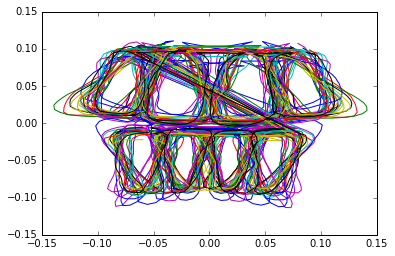

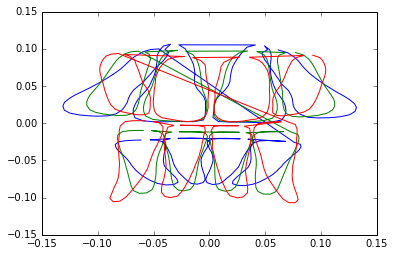

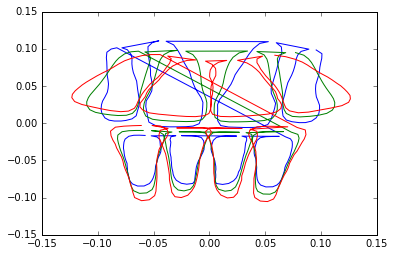

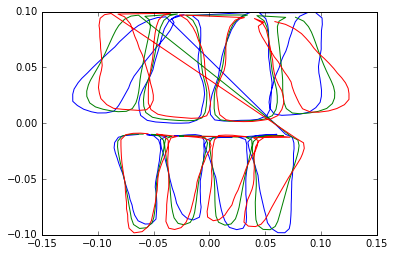

In [4]:
lc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH,True)
landmarks = lc + mlc
model = ShapeModel(landmarks)
plot_shapes(model.aligned_shapes())
#plot_shapes([model.mean_shape()])
plot_shapes(model.mode_shapes(1))
plot_shapes(model.mode_shapes(2))
plot_shapes(model.mode_shapes(3))

### Some edge detection and pyramids

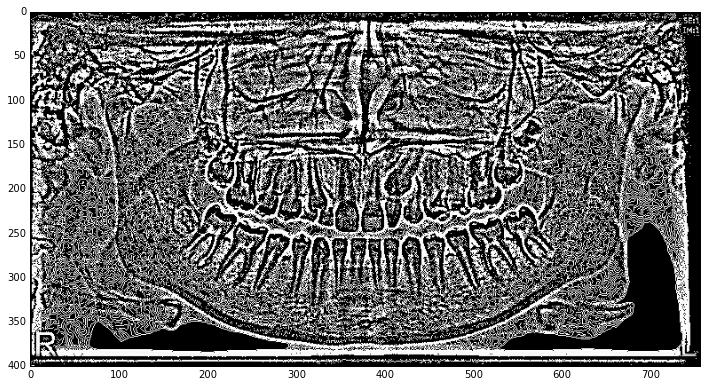

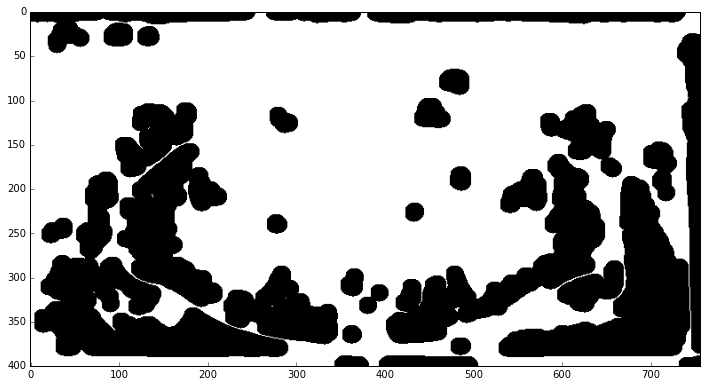

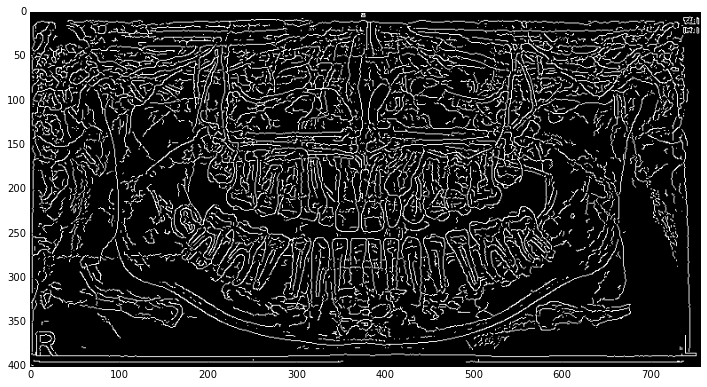

In [5]:
sample = cv2.pyrDown(cv2.pyrDown(data.get_extra_images([0])[0]))#[650:1300,1200:1800]
imshow2(cv2.Laplacian(cv2.bilateralFilter(sample,5,30,30),2))
imshow2(cv2.morphologyEx(cv2.Canny(cv2.bilateralFilter(sample,9,30,30),20,20),cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))))
imshow2(cv2.Canny(cv2.bilateralFilter(sample,5,30,30),10,20))

#### Shape normals

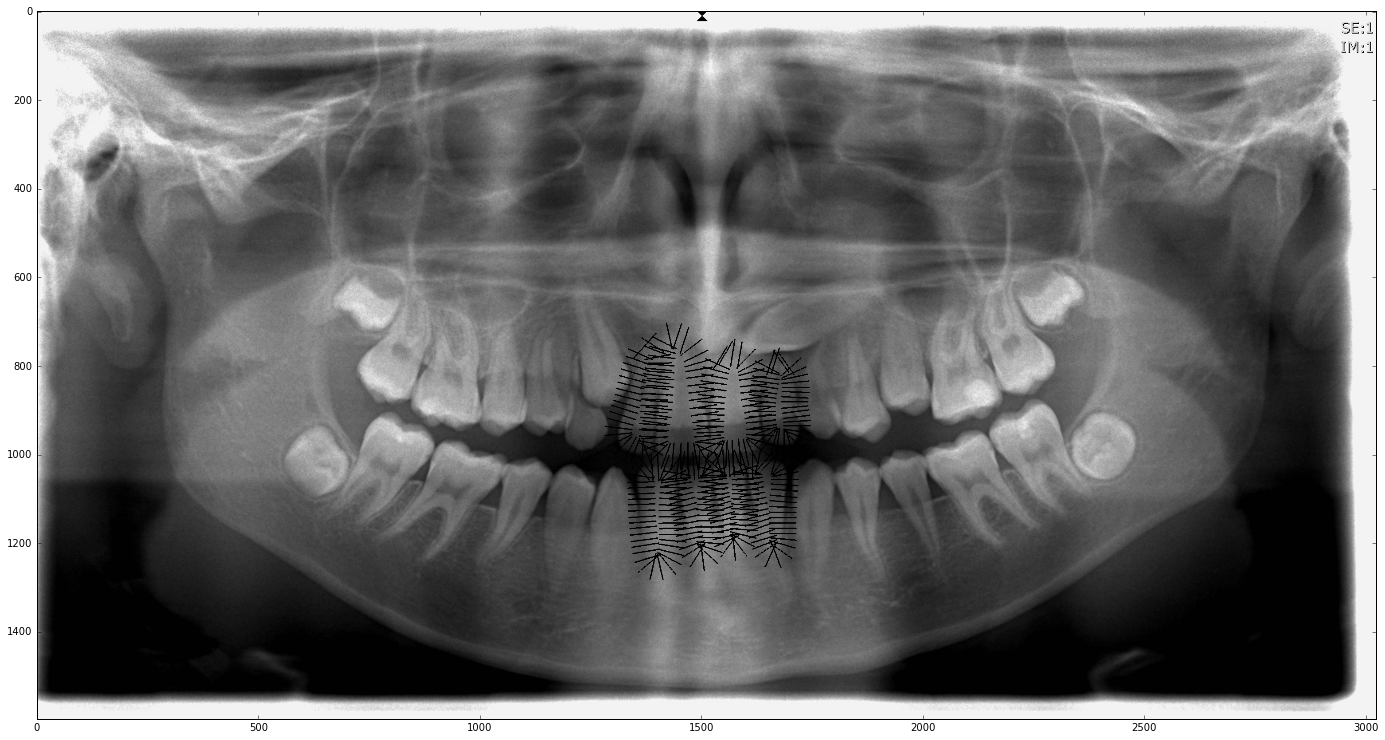

In [6]:
img,_ = data.get_training_images([0])
l,_ = data.get_training_image_landmarks([0],Dataset.ALL_TEETH,combine=True)
shape = l[0]
normal_pixels = []
for i in range(shape.size()):
    generator = shape.get_normal_at_point_generator(i, 2)
    for increment in range(-30, 31):
        coordinates = np.int32(np.round(generator(increment)))
        normal_pixels.append(coordinates.tolist())
imshow2(overlay_points_on_image(img[0],normal_pixels),width=24,height=24)

#### Grey Level pixels for the shape normals

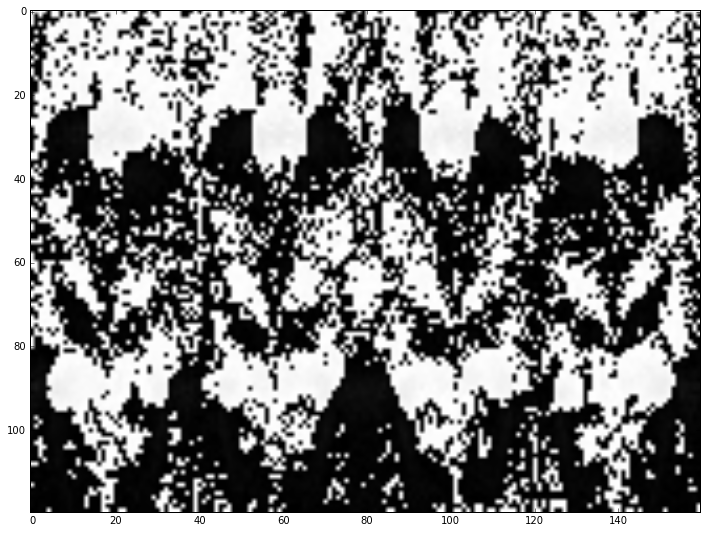

In [7]:
img,mimg = data.get_training_images(Dataset.ALL_TRAINING_IMAGES)
l,ml = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH,combine=True)
images = img + mimg
shapes = l+ml
greymodel = GreyModel(images,shapes,number_of_pixels=30,normalize=True,use_gradient=True)
img = np.array([greymodel.get_point_grey_model(point_index).mean() for point_index in range(greymodel.size())])
img = np.concatenate((img[:][:160],img[:][160:]),axis=1)
imshow2(np.uint8(np.round(100*img.T),width=24,height=24))

#### Fun with pyramids

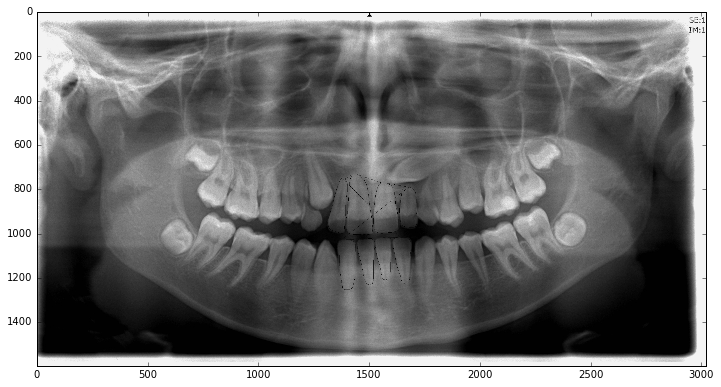

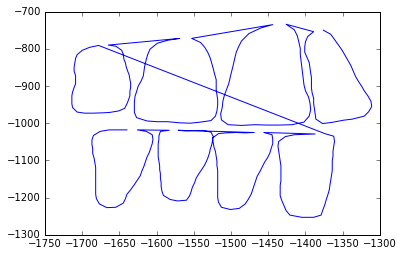

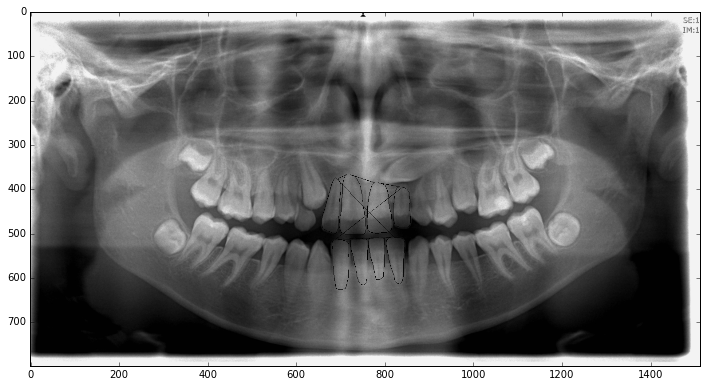

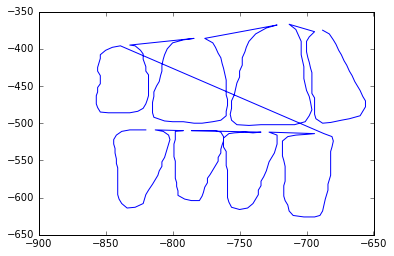

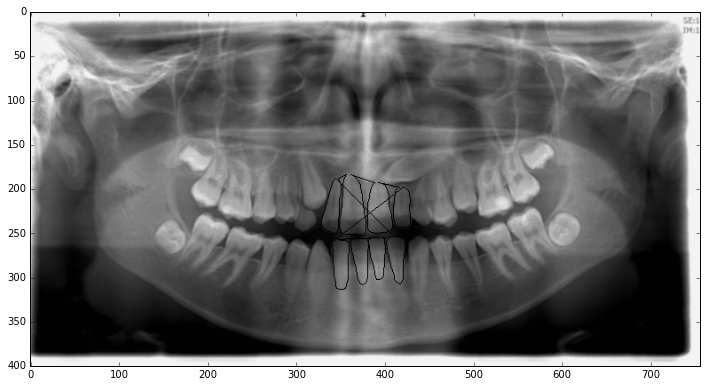

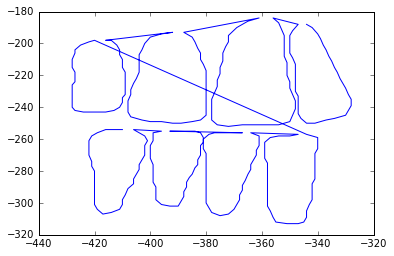

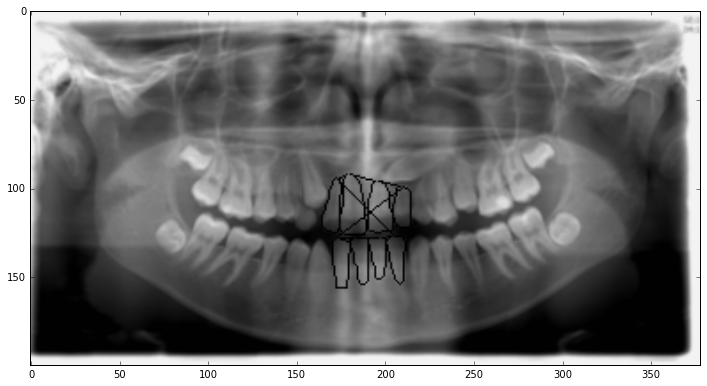

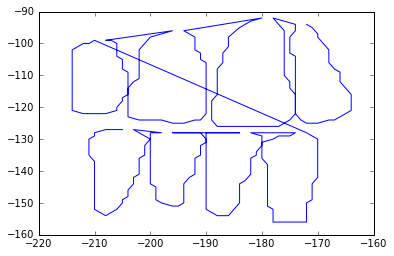

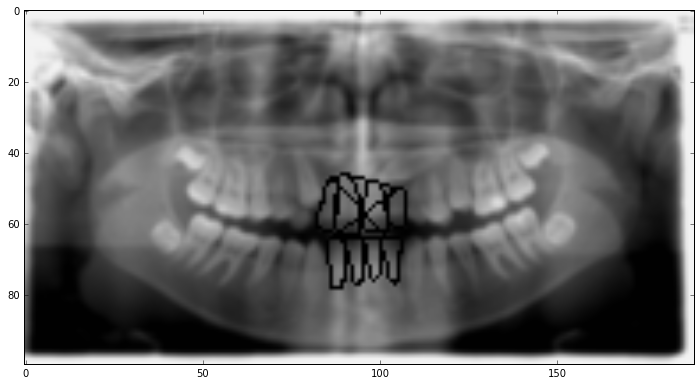

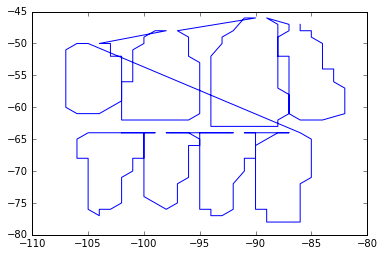

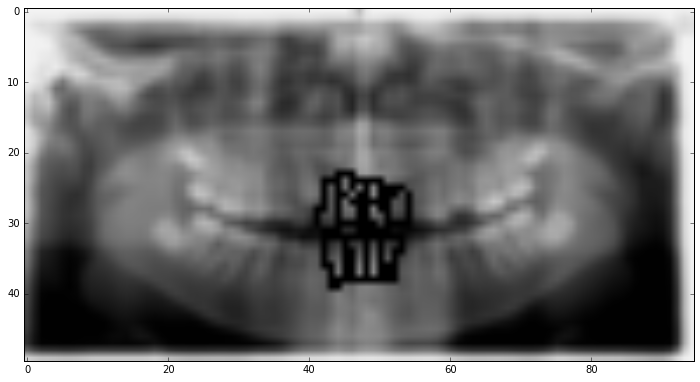

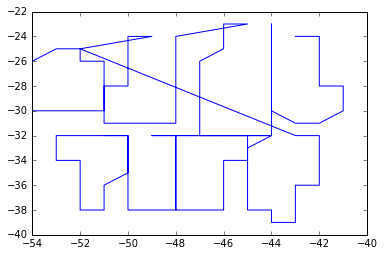

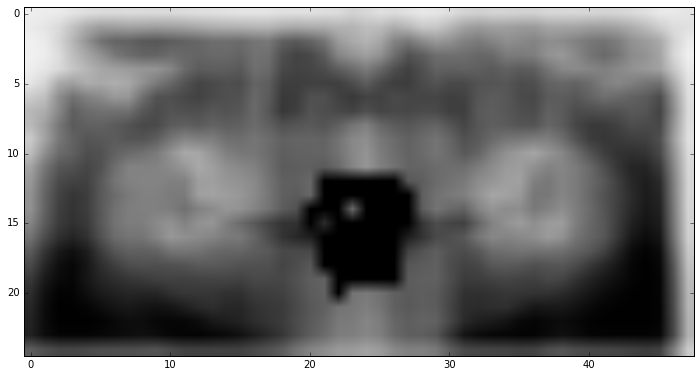

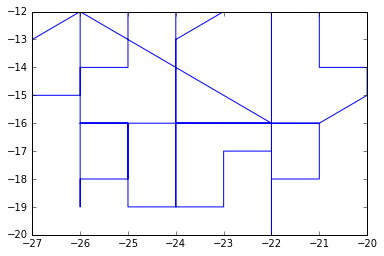

In [8]:
pimg = images[0]
shape = shapes[0]
for i in range(7):
    imshow2(overlay_shapes_on_image(pimg,[shape]))
    plot_shapes([shape])
    pimg = cv2.pyrDown(pimg)
    shape = shape.pyr_down()

#### Leave 1 out CV

In [9]:
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    print split.get_dice_error_on_test(test_landmark)
    print split.get_dice_error_on_test(test_landmark,True)

0.720707254052
1.0
0.669511433775
1.0
0.729179738404
1.0
0.637585157835
1.0
0.709117801352
1.0
0.729491151966
1.0
0.724374616493
1.0
0.77594077993
1.0
0.739836868925
1.0
0.688420985772
1.0
0.746843293974
1.0
0.742366518199
1.0
0.73442359028
1.0
0.74423645432
1.0
0.71908182386
1.0
0.663929844849
1.0
0.724063927488
1.0
0.626929818866
1.0
0.706354587421
1.0
0.726144010536
1.0
0.719348130544
1.0
0.762255186612
1.0
0.739087421277
1.0
0.682712685437
1.0
0.741636994003
1.0
0.731514366958
1.0
0.730152073479
1.0
0.735166400826
1.0


(28, 320, 2)
(320, 2)


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'\nX_orig = np.rint(X_orig/28)\nY_orig = np.rint(Y_orig/28)\n\npimg = images[0]\nfor pimg in images:\n    XY_orig = np.uint32([X_orig, Y_orig])\n    for i in range(4):\n        print XY_orig\n        if i==3:\n            imshow2(overlay_points_on_image(pimg,[XY_orig]))\n        pimg = cv2.pyrDown(pimg)\n        XY_orig = XY_orig/2\n'

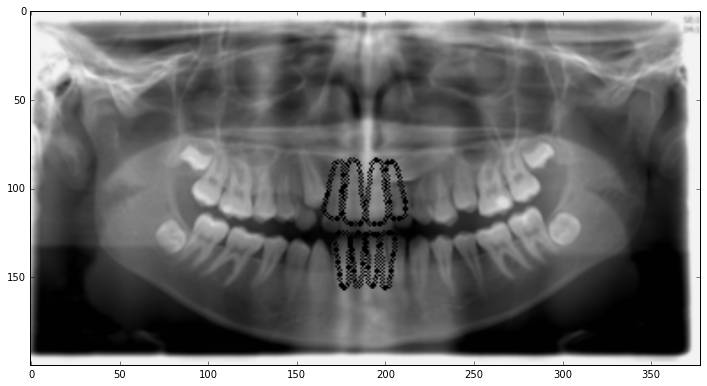

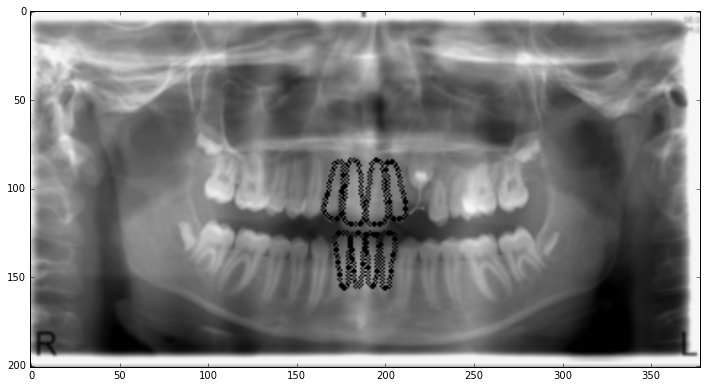

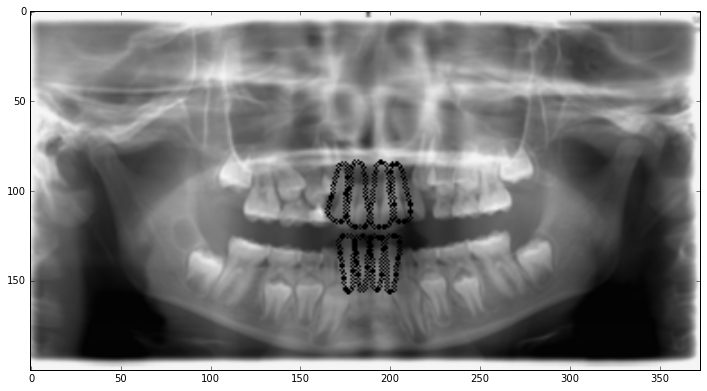

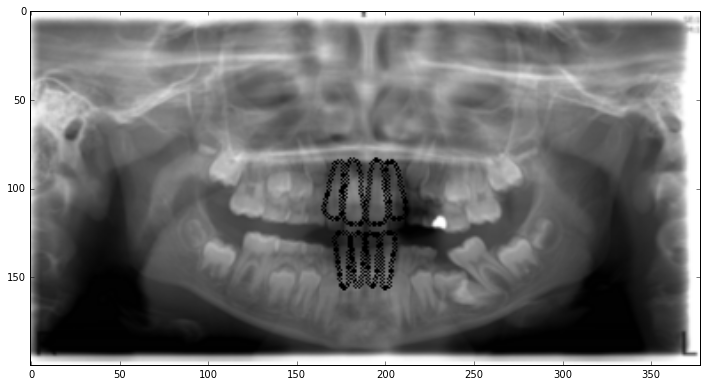

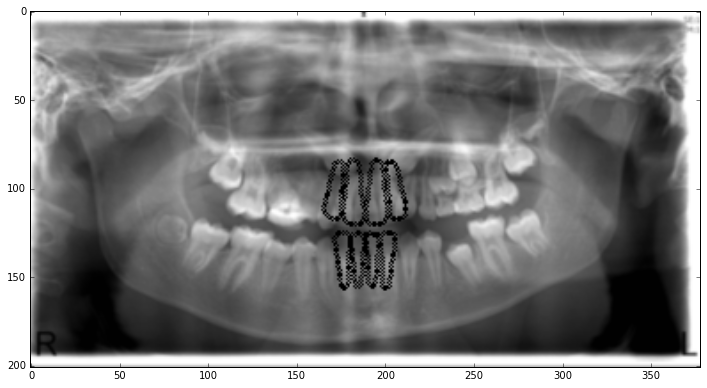

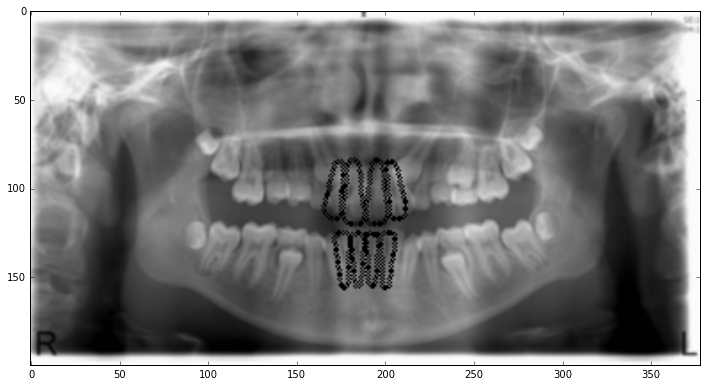

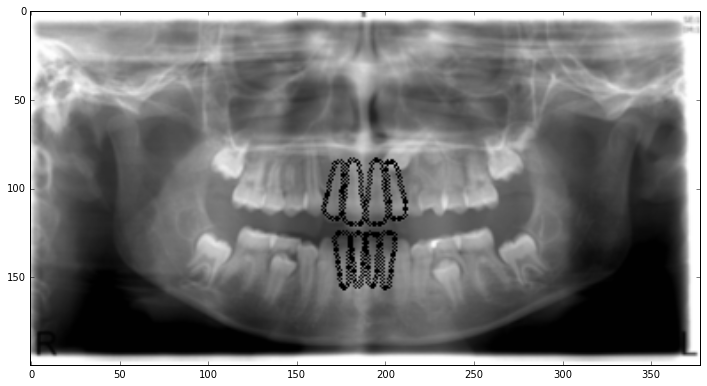

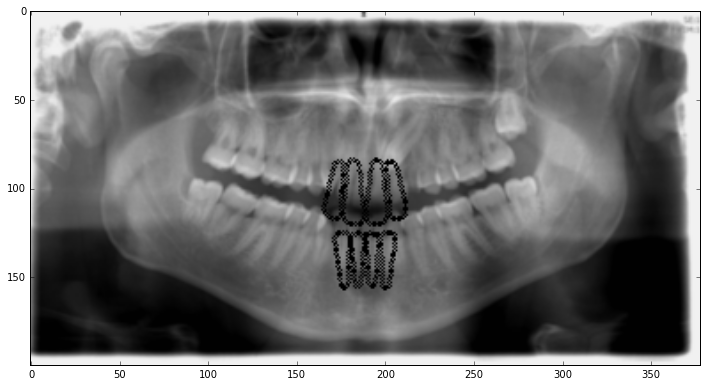

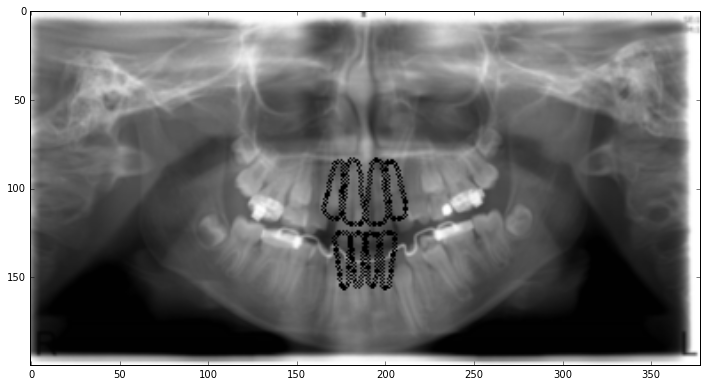

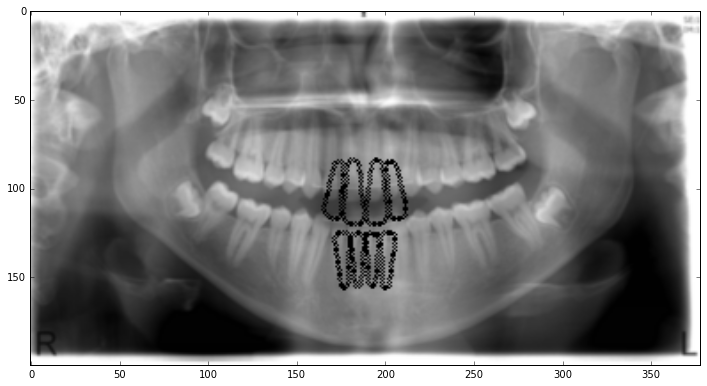

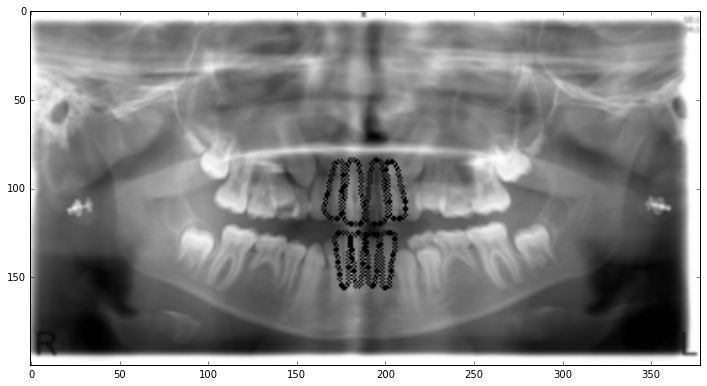

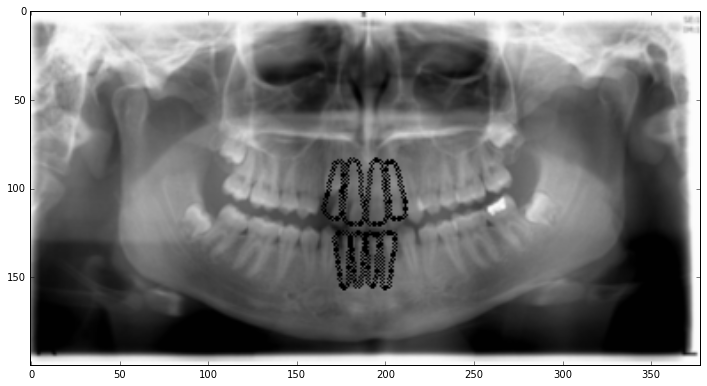

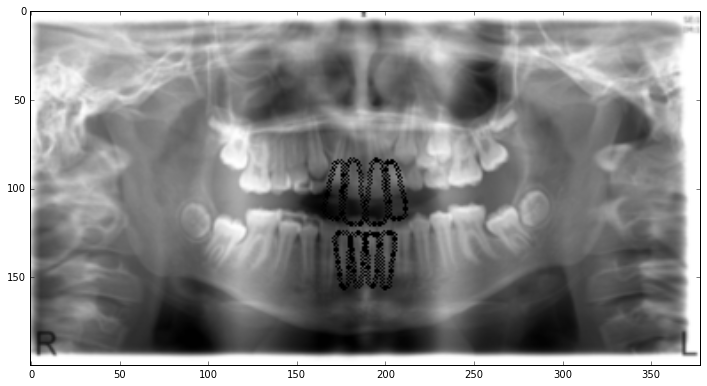

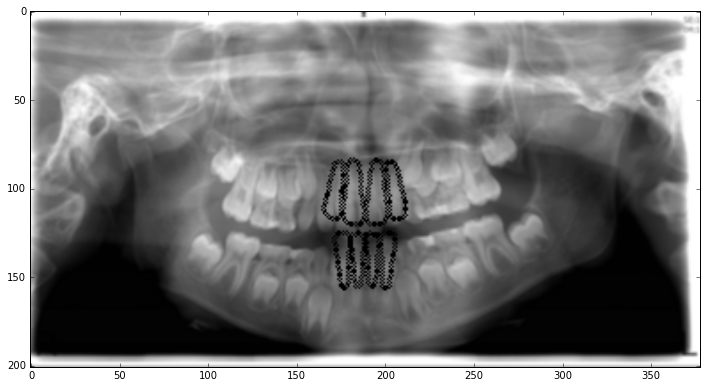

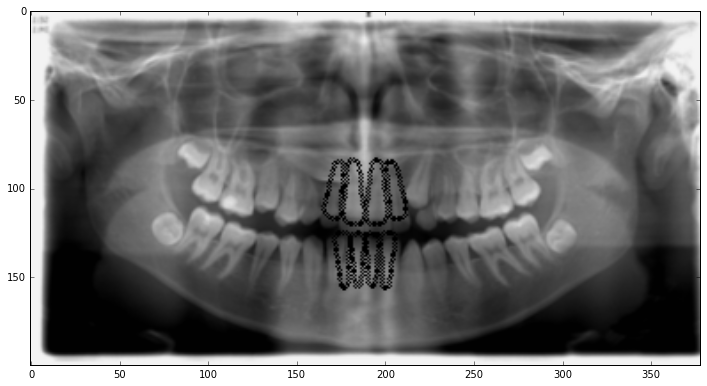

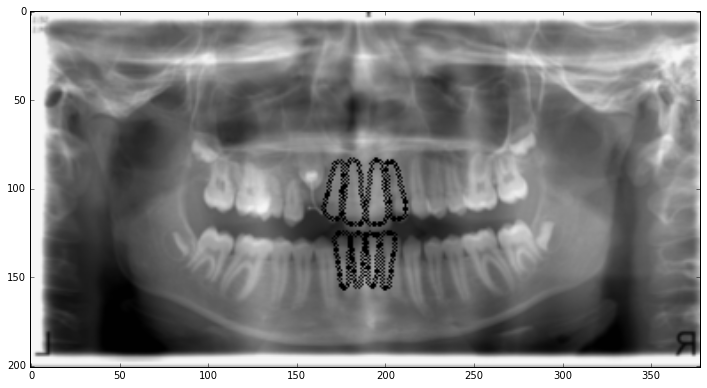

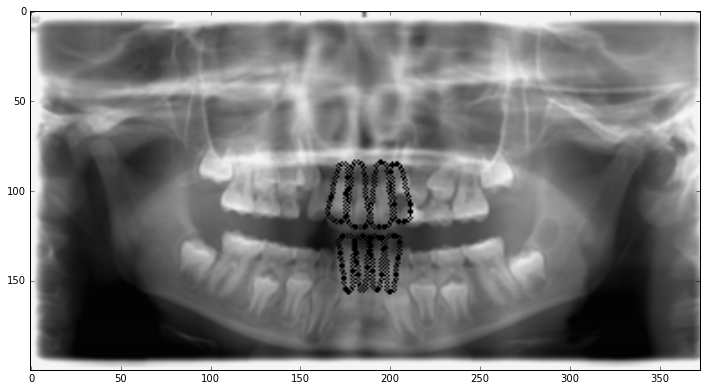

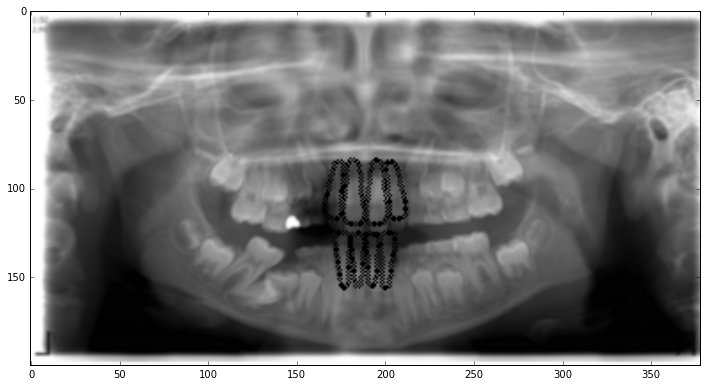

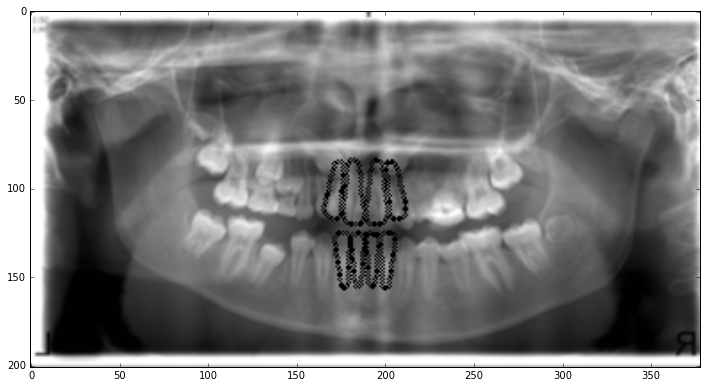

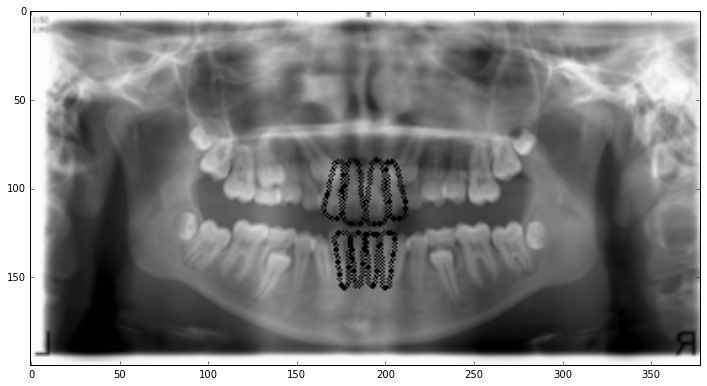

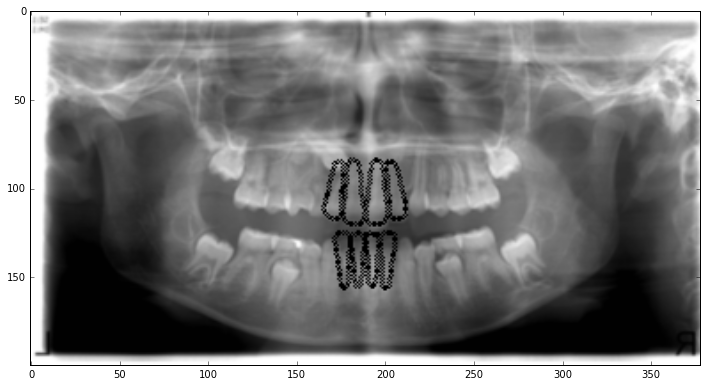

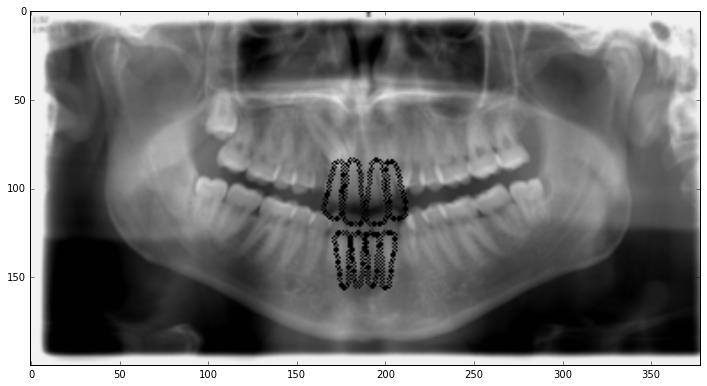

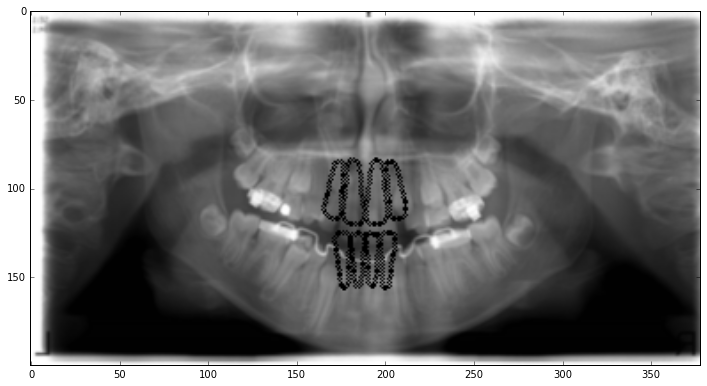

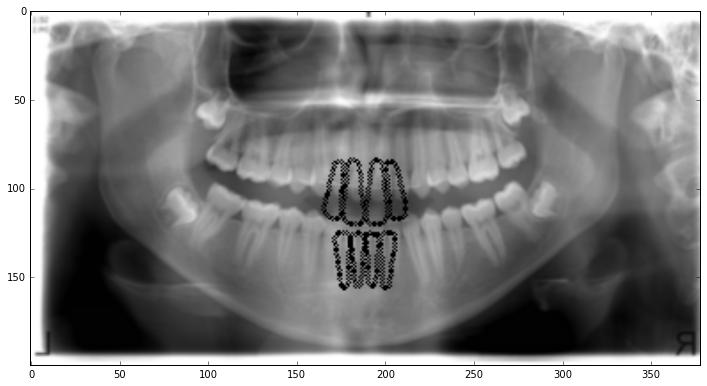

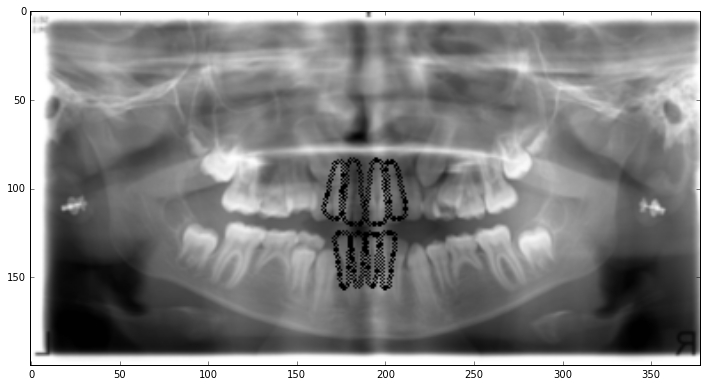

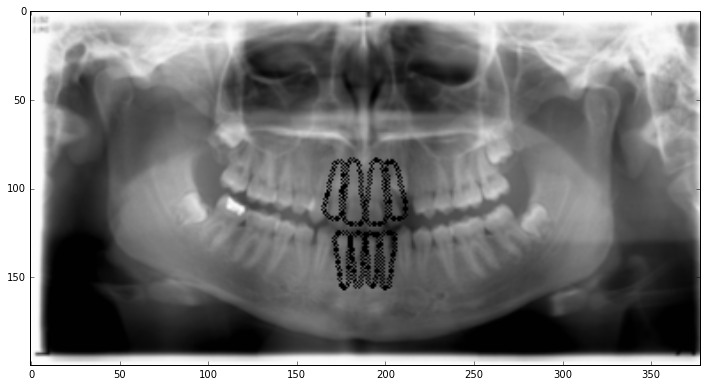

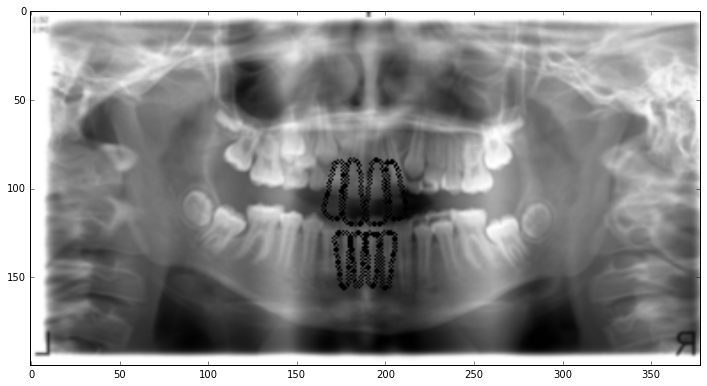

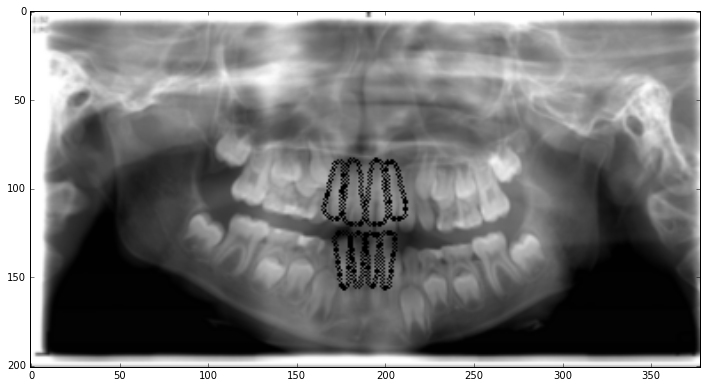

In [10]:
#X_orig = np.zeros(320)
#Y_orig = np.zeros(320)

point_matrix = []
for shape in shapes:
    point_matrix.append(shape.raw())
point_matrix=np.array(point_matrix)
print point_matrix.shape
point_matrix = np.uint32(np.round(np.mean(point_matrix,axis=0)))
print point_matrix.shape

for pimg in images:
    point_matrix_level = point_matrix
    for i in range(6):
        if i==3:
            imshow2(overlay_points_on_image(pimg,point_matrix_level.tolist()))
        pimg = cv2.pyrDown(pimg)
        point_matrix_level = np.uint32(np.round(point_matrix_level/2))



    #for i in range(320):
    #X_orig+=shape.raw()[0][0]
    #Y_orig+=shape.raw()[0][1]
"""
X_orig = np.rint(X_orig/28)
Y_orig = np.rint(Y_orig/28)

pimg = images[0]
for pimg in images:
    XY_orig = np.uint32([X_orig, Y_orig])
    for i in range(4):
        print XY_orig
        if i==3:
            imshow2(overlay_points_on_image(pimg,[XY_orig]))
        pimg = cv2.pyrDown(pimg)
        XY_orig = XY_orig/2
"""

In [11]:
aligned_shapes = np.array([shape.raw() for shape in model.aligned_shapes()])
print aligned_shapes.shape
align_min = np.min(np.min(aligned_shapes, axis=0),axis=0)
align_max = np.max(np.max(aligned_shapes, axis=0),axis=0)
print align_min
print align_max
aligned_shapes_bb = get_bounding_box(model.aligned_shapes())
original_shapes_bb = get_bounding_box([model.get_initial_translation()])
scale_factor = (np.diff(original_shapes_bb, axis=0)/np.diff(aligned_shapes_bb, axis=0))[0]
mean_rotation_matrix = model.mean_rotation()
print scale_factor
print model.get_initial_translation().mean()
print  model.get_initial_translation().mean()+[scale_factor[0]*align_min[0], scale_factor[1]*align_min[1]]
print  model.get_initial_translation().mean()+[scale_factor[0]*align_max[0], scale_factor[1]*align_max[1]]
print mean_rotation_matrix

(28, 320, 2)
[-0.14124984 -0.11061855]
[ 0.13933251  0.11349792]
[ 1315.12191025  2587.9400345 ]
[ 1510.1      970.5375]
[ 1324.33924137   684.26332226]
[ 1693.33924137  1264.26332226]
[[  1.00000000e+00  -2.76771325e-16]
 [ -4.72807880e-16   1.00000000e+00]]
